In [1]:
!pip install pycocoevalcap
!pip install wordfreq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 17.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 MB 34.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.3 MB/s eta 0:00:00


In [4]:

import os
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from torchvision import models, transforms
from tqdm import tqdm
from datasets import load_dataset
from typing import List
from collections import Counter
import math
import re
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
def basic_tokenize(text: str) -> List[str]:
    text = text.lower().strip()
    text = re.sub(r'([.,!?;:()])', r' \1 ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.split()

class SimpleTokenizer:
    def __init__(self, vocab: List[str]):
        specials = ["<pad>", "<bos>", "<eos>", "<unk>"]
        vocab = specials + [w for w in vocab if w not in specials]
        self.stoi = {w: i for i, w in enumerate(vocab)}
        self.itos = {i: w for w, i in self.stoi.items()}
        self.pad_id = self.stoi["<pad>"]
        self.bos_id = self.stoi["<bos>"]
        self.eos_id = self.stoi["<eos>"]
        self.unk_id = self.stoi["<unk>"]

    def encode(self, text: str) -> List[int]:
        tokens = basic_tokenize(text)
        return [self.stoi.get(t, self.unk_id) for t in tokens]

    def decode(self, ids: List[int]) -> str:
        toks = []
        for i in ids:
            if i in (self.pad_id, self.bos_id, self.eos_id):
                continue
            toks.append(self.itos.get(i, "<unk>"))
        sent = " ".join(toks)
        sent = re.sub(r'\s+([.,!?;:])', r'\1', sent)
        return sent

def collect_rsicd_words(hf_train, hf_val, min_freq=3):
    cnt = Counter()
    for split in [hf_train, hf_val]:
        for ex in split:
            cap = ex["captions"]
            if isinstance(cap, list):
                for c in cap:
                    cnt.update(basic_tokenize(c))
            else:
                cnt.update(basic_tokenize(cap))
    words = [w for w, freq in cnt.most_common() if freq >= min_freq]
    return words


ds = load_dataset("arampacha/rsicd")
rsicd_words = collect_rsicd_words(ds["train"], ds["valid"], min_freq=3)
print(f"RSICD unique words (freq >=3): {len(rsicd_words)}")

try:
    from wordfreq import top_n_list
    gigaword_top = top_n_list("en", n=5000)
    merged = list(dict.fromkeys(rsicd_words + gigaword_top))
    print(f"After adding wordfreq top-5k: {len(merged)}")
except:
    print("Wordfreq not available, using RSICD only")
    merged = rsicd_words

tokenizer = SimpleTokenizer(merged)
print(f"Final vocab size: {len(tokenizer.stoi)}")

RSICD unique words (freq >=3): 1568
After adding wordfreq top-5k: 5740
Final vocab size: 5744


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])
class RSICDDataset(Dataset):
    def __init__(self, hf_split, tokenizer, transform=None, max_len=25, is_train=True):
        self.data = hf_split
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_len = max_len
        self.is_train = is_train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        ex = self.data[idx]

        img_path = ex.get("image_path", ex.get("image"))
        if isinstance(img_path, str):
            image = Image.open(img_path).convert("RGB")
        else:
            image = ex["image"]
            if not isinstance(image, Image.Image):
                image = Image.fromarray(np.array(image))

        if self.transform is not None:
            image = self.transform(image)

        caps = ex["captions"]
        if isinstance(caps, str):
            caps = [caps]
        caps = [c.strip() for c in caps if isinstance(c, str) and c.strip()]
        if len(caps) == 0:
            caps = ["empty image"]

        if self.is_train:
            caption = random.choice(caps)
        else:
            caption = caps[0]

        caption_ids = self.tokenizer.encode(caption)
        caption_ids = [self.tokenizer.bos_id] + caption_ids + [self.tokenizer.eos_id]
        caption_ids = caption_ids[:self.max_len]

        pad_len = self.max_len - len(caption_ids)
        if pad_len > 0:
            caption_ids = caption_ids + [self.tokenizer.pad_id] * pad_len

        caption_ids = torch.tensor(caption_ids, dtype=torch.long)

        return image, caption_ids, caps


def collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    caption_ids = torch.stack([item[1] for item in batch])
    all_captions = [item[2] for item in batch]
    return images, caption_ids, all_captions

In [7]:
batch_size = 64
max_len = 25

train_data = RSICDDataset(ds["train"], tokenizer, transform=train_transform, max_len=max_len, is_train=True)
val_data = RSICDDataset(ds["valid"], tokenizer, transform=val_transform, max_len=max_len, is_train=False)
test_data = RSICDDataset(ds["test"], tokenizer, transform=val_transform, max_len=max_len, is_train=False)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_fn)

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

Train: 8734, Val: 1094, Test: 1093


In [ ]:
class ResNetEncoder(nn.Module):
    def __init__(self, output_dim=512, dropout_p=0.5):
        super().__init__()
        base_model = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2)

        for param in list(base_model.parameters())[:-30]:
            param.requires_grad = False

        modules = list(base_model.children())[:-2]
        self.cnn = nn.Sequential(*modules)
        in_features = 2048 

        self.spatial_proj = nn.Conv2d(in_features, output_dim, kernel_size=1)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_features, output_dim)
        self.bn = nn.BatchNorm1d(output_dim)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        with torch.set_grad_enabled(self.training):
            feats = self.cnn(x)

        spatial = self.spatial_proj(feats)
        B, C, H, W = spatial.size()
        spatial = spatial.view(B, C, H * W).transpose(1, 2)

        global_feats = self.avgpool(feats).view(B, -1)
        global_feats = self.fc(global_feats)
        global_feats = self.bn(global_feats)
        global_feats = self.dropout(global_feats)

        return spatial, global_feats


class SpatialAttention(nn.Module):
    def __init__(self, hidden_dim, feat_dim):
        super().__init__()
        self.hidden_proj = nn.Linear(hidden_dim, feat_dim)
        self.feat_proj = nn.Linear(feat_dim, feat_dim)
        self.attention = nn.Linear(feat_dim, 1)

    def forward(self, hidden, spatial_feats):
        h_proj = self.hidden_proj(hidden).unsqueeze(1)

        f_proj = self.feat_proj(spatial_feats)

        combined = torch.tanh(h_proj + f_proj)
        scores = self.attention(combined).squeeze(-1)

        alpha = F.softmax(scores, dim=1)

        context = torch.bmm(alpha.unsqueeze(1), spatial_feats).squeeze(1)  # (B, feat_dim)

        return context, alpha


In [ ]:
class AttentionLSTMDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=512, hidden_dim=512, feat_dim=512, num_layers=3, dropout_p=0.5):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.dropout_embed = nn.Dropout(dropout_p)

        self.attention = SpatialAttention(hidden_dim, feat_dim)

        self.lstm = nn.LSTM(
            embed_dim + feat_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_p if num_layers > 1 else 0
        )

        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(hidden_dim, vocab_size)

        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def forward(self, spatial_feats, global_feats, caption_ids):
        B, T = caption_ids.size()

        h = global_feats.unsqueeze(0).repeat(self.num_layers, 1, 1)
        c = torch.zeros_like(h)

        embeddings = self.embed(caption_ids)
        embeddings = self.dropout_embed(embeddings)

        outputs = []
        for t in range(T):
            current_h = h[-1]

            context, _ = self.attention(current_h, spatial_feats)

            lstm_input = torch.cat([embeddings[:, t:t+1, :], context.unsqueeze(1)], dim=2)

            out, (h, c) = self.lstm(lstm_input, (h, c))
            outputs.append(out)

        outputs = torch.cat(outputs, dim=1)
        outputs = self.dropout(outputs)
        logits = self.fc(outputs)

        return logits

In [ ]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, caption_ids):
        spatial_feats, global_feats = self.encoder(images)
        logits = self.decoder(spatial_feats, global_feats, caption_ids[:, :-1])
        return logits

    def sample_caption(self, spatial_feats, global_feats, max_len, start_token_id, end_token_id, pad_id=0, sample=False):
        B = global_feats.size(0)
        device = global_feats.device

        h = global_feats.unsqueeze(0).repeat(self.decoder.num_layers, 1, 1)
        c = torch.zeros_like(h)

        sequences = torch.full((B, max_len), pad_id, dtype=torch.long, device=device)
        sequences[:, 0] = start_token_id

        log_probs_list = []
        current_word = torch.full((B,), start_token_id, dtype=torch.long, device=device)

        active_mask = torch.ones(B, dtype=torch.bool, device=device)

        for t in range(1, max_len):
            current_h = h[-1]
            context, _ = self.decoder.attention(current_h, spatial_feats)

            word_emb = self.decoder.embed(current_word).unsqueeze(1)
            lstm_input = torch.cat([word_emb, context.unsqueeze(1)], dim=2)

            out, (h, c) = self.decoder.lstm(lstm_input, (h, c))
            logits = self.decoder.fc(out.squeeze(1))
            log_probs = F.log_softmax(logits, dim=-1)

            if sample:
                temperature = 1.0
                probs = torch.exp(log_probs / temperature)
                next_word = torch.multinomial(probs, 1).squeeze(1)
            else:
                next_word = log_probs.argmax(dim=-1)

            sequences[active_mask, t] = next_word[active_mask]

            selected_log_probs = log_probs.gather(1, next_word.unsqueeze(1)).squeeze(1)
            log_probs_list.append(selected_log_probs)

            active_mask = active_mask & (next_word != end_token_id)

            current_word = next_word

            if not active_mask.any():
                break

        if log_probs_list:
            log_probs_seq = torch.stack(log_probs_list, dim=1)

            expected_len = max_len - 1
            current_len = log_probs_seq.size(1)

            if current_len < expected_len:
                pad_size = expected_len - current_len
                log_probs_seq = F.pad(log_probs_seq, (0, pad_size), value=0.0)
        else:
            log_probs_seq = torch.zeros(B, max_len - 1, device=device)

        return sequences, log_probs_seq


    def generate_caption_bleu4(
        self,
        image,
        tokenizer,
        max_len=25,
        beam_size=5,
        alpha=0.7,
        device="cuda"
    ):
        self.eval()
    
        if image.dim() == 3:
            image = image.unsqueeze(0)
        image = image.to(device)
    
        spatial_feats, global_feats = self.encoder(image)
    
        bos_id = tokenizer.bos_id
        eos_id = tokenizer.eos_id
        pad_id = tokenizer.pad_id
        vocab_size = self.decoder.vocab_size
    
        seqs = torch.full((beam_size, 1), bos_id, dtype=torch.long, device=device)
        log_probs = torch.zeros(beam_size, device=device)
        finished = torch.zeros(beam_size, dtype=torch.bool, device=device)
    
        spatial_feats = spatial_feats.expand(beam_size, -1, -1)
        global_feats = global_feats.expand(beam_size, -1)
    
        for t in range(1, max_len + 1):
            if finished.all():
                break
    
            logits = self.decoder(spatial_feats, global_feats, seqs)
            step_logits = logits[:, -1, :]
            step_log_probs = F.log_softmax(step_logits, dim=-1)
    
            step_log_probs[:, pad_id] = -1e9
            total_log_probs = log_probs.unsqueeze(1) + step_log_probs   # (B, vocab)
    
            # ==== PHẦN MASK ĐÃ SỬA ====
            # beam đã kết thúc: chỉ giữ log_prob tại EOS, cấm token khác
            if finished.any():
                # đặt -inf cho tất cả token của những beam đã kết thúc
                total_log_probs[finished] = -1e9
                # gán lại log_prob tại EOS đúng bằng log_probs cũ
                total_log_probs[finished, eos_id] = log_probs[finished]
            # ===========================
    
            flat_log_probs = total_log_probs.view(-1)
            topk_log_probs, topk_indices = flat_log_probs.topk(beam_size, dim=-1)
    
            beam_indices = topk_indices // vocab_size
            token_indices = topk_indices % vocab_size
    
            seqs = torch.cat([seqs[beam_indices], token_indices.unsqueeze(1)], dim=1)
            log_probs = topk_log_probs
            finished = finished[beam_indices] | (token_indices == eos_id)
    
            if seqs.size(1) >= 4:
                for b in range(beam_size):
                    seq_b = seqs[b].tolist()
                    last_trigram = tuple(seq_b[-3:])
                    for i in range(len(seq_b) - 3):
                        if tuple(seq_b[i:i+3]) == last_trigram:
                            log_probs[b] -= 2.0
                            break
    
        lengths = (seqs != pad_id).sum(dim=1).float()
        lengths = torch.clamp(lengths - 1, min=1.0)
        lp = ((5.0 + lengths) / 6.0) ** alpha
        scores = log_probs / lp
    
        best_idx = scores.argmax().item()
        best_seq = seqs[best_idx].tolist()
        best_seq = [tok for tok in best_seq if tok not in (bos_id, eos_id, pad_id)]
        return best_seq


In [11]:
vocab_size = len(tokenizer.stoi)
embed_dim = 512
hidden_dim = 512
feat_dim = 512

encoder = ResNetEncoder(output_dim=feat_dim, dropout_p=0.5)
decoder = AttentionLSTMDecoder(vocab_size, embed_dim, hidden_dim, feat_dim, num_layers=1, dropout_p=0.5)
model = ImageCaptioningModel(encoder, decoder).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:00<00:00, 192MB/s] 


Model parameters: 26,102,385


In [ ]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, vocab_size, padding_idx, smoothing=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.vocab_size - 2))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
            true_dist[:, self.padding_idx] = 0
            mask = (target == self.padding_idx)
            true_dist[mask] = 0

        loss = -(true_dist * pred).sum(dim=-1)
        loss = loss.masked_fill(mask, 0).sum() / (mask == 0).sum()
        return loss


criterion = LabelSmoothingLoss(vocab_size, tokenizer.pad_id, smoothing=0.1)
optimizer = torch.optim.AdamW([
    {'params': encoder.parameters(), 'lr': 1e-5},
    {'params': decoder.parameters(), 'lr': 5e-4}
], weight_decay=1e-4)
num_epochs = 30

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

In [ ]:
def train_one_epoch_xe(model, loader, optimizer, criterion, device, scheduled_sampling_prob=0.0):
    model.train()
    total_loss = 0.0

    for images, caption_ids, _ in tqdm(loader, desc="Train (XE)", leave=False):
        images = images.to(device)
        caption_ids = caption_ids.to(device)
        B, T = caption_ids.size()

        spatial_feats, global_feats = model.encoder(images)

        if scheduled_sampling_prob > 0 and random.random() < scheduled_sampling_prob:
            logits = []
            h = global_feats.unsqueeze(0).repeat(model.decoder.num_layers, 1, 1)
            c = torch.zeros_like(h)

            input_token = caption_ids[:, 0]
            for t in range(T - 1):
                current_h = h[-1]
                context, _ = model.decoder.attention(current_h, spatial_feats)
                word_emb = model.decoder.embed(input_token).unsqueeze(1)
                lstm_input = torch.cat([word_emb, context.unsqueeze(1)], dim=2)
                out, (h, c) = model.decoder.lstm(lstm_input, (h, c))
                out = model.decoder.dropout(out)
                logit = model.decoder.fc(out.squeeze(1))
                logits.append(logit.unsqueeze(1))

                if random.random() < 0.5:
                    input_token = logit.argmax(dim=-1)
                else:
                    input_token = caption_ids[:, t + 1]

            logits = torch.cat(logits, dim=1)
        else:
            logits = model(images, caption_ids)

        target = caption_ids[:, 1:]
        loss = criterion(logits.reshape(-1, vocab_size), target.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def compute_cider_score(refs, hyps, return_per_sample=False):
    cider_scorer = Cider()
    score, scores = cider_scorer.compute_score(refs, hyps)
    if return_per_sample:
        return scores
    else:
        return score


def train_one_epoch_scst(model, loader, tokenizer, optimizer, device, baseline_type='greedy'):
    model.train()
    total_loss, total_reward, num_batches = 0.0, 0.0, 0

    for images, caption_ids, all_caps_batch in tqdm(loader, desc="Train (SCST)", leave=False):
        images = images.to(device)
        B = images.size(0)

        spatial_feats, global_feats = model.encoder(images)

        sampled_seqs, sampled_log_probs = model.sample_caption(
            spatial_feats, global_feats,
            max_len=25,
            start_token_id=tokenizer.bos_id,
            end_token_id=tokenizer.eos_id,
            pad_id=tokenizer.pad_id,
            sample=True
        )

        with torch.no_grad():
            baseline_seqs, _ = model.sample_caption(
                spatial_feats, global_feats,
                max_len=25,
                start_token_id=tokenizer.bos_id,
                end_token_id=tokenizer.eos_id,
                pad_id=tokenizer.pad_id,
                sample=False
            )

        refs_batch, sampled_batch, baseline_batch = {}, {}, {}
        valid_indices = []
        for i in range(B):
            sampled_text = tokenizer.decode(sampled_seqs[i].tolist()).strip()
            baseline_text = tokenizer.decode(baseline_seqs[i].tolist()).strip()
            if not sampled_text or not baseline_text:
                continue
            refs_batch[i] = all_caps_batch[i]
            sampled_batch[i] = [sampled_text]
            baseline_batch[i] = [baseline_text]
            valid_indices.append(i)

        if len(valid_indices) == 0:
            continue

        sampled_scores = compute_cider_score(refs_batch, sampled_batch, return_per_sample=True)
        baseline_scores = compute_cider_score(refs_batch, baseline_batch, return_per_sample=True)

        rewards = torch.tensor(
            [s - b for s, b in zip(sampled_scores, baseline_scores)],
            device=device, dtype=torch.float32
        )

        valid_log_probs = sampled_log_probs[valid_indices]
        valid_seqs = sampled_seqs[valid_indices]
        mask = (valid_seqs != tokenizer.pad_id).float()

        log_probs_sum = (valid_log_probs * mask[:, 1:]).sum(dim=1)
        seq_lengths = mask[:, 1:].sum(dim=1)
        normalized_log_probs = log_probs_sum / (seq_lengths + 1e-8)

        loss = -(normalized_log_probs * rewards).mean()

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        total_loss += loss.item()
        total_reward += rewards.mean().item()
        num_batches += 1

    avg_loss = total_loss / max(num_batches, 1)
    avg_reward = total_reward / max(num_batches, 1)
    return avg_loss, avg_reward


def evaluate(model, loader, tokenizer, device, max_samples=None):
    model.eval()
    total_loss = 0.0
    refs = {}
    hyps = {}
    idx = 0

    with torch.no_grad():
        for images, caption_ids, all_caps_batch in tqdm(loader, desc="Eval", leave=False):
            images = images.to(device)
            caption_ids = caption_ids.to(device)

            logits = model(images, caption_ids)
            target = caption_ids[:, 1:]
            loss = criterion(logits.reshape(-1, vocab_size), target.reshape(-1))
            total_loss += loss.item()

            for i in range(images.size(0)):
                if max_samples and idx >= max_samples:
                    break

                img = images[i].unsqueeze(0)
                token_ids = model.generate_caption(
                    img,
                    tokenizer.bos_id,
                    tokenizer.eos_id,
                    max_len=25,
                    beam_size=5,
                    diversity_penalty=0.5
                )

                hyp = tokenizer.decode(token_ids)
                refs[idx] = all_caps_batch[i]
                hyps[idx] = [hyp]
                idx += 1

            if max_samples and idx >= max_samples:
                break

    avg_loss = total_loss / len(loader)

    bleu_scorer = Bleu(4)
    bleu_scores, _ = bleu_scorer.compute_score(refs, hyps)

    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(refs, hyps)

    return avg_loss, bleu_scores[3], cider_score


def test_evaluation(model, loader, tokenizer, device):
    model.eval()
    total_loss = 0.0
    refs = {}
    hyps = {}
    idx = 0

    print("Generating captions for test set...")
    with torch.no_grad():
        for images, caption_ids, all_caps_batch in tqdm(loader, desc="Test"):
            images = images.to(device)
            caption_ids = caption_ids.to(device)

            logits = model(images, caption_ids)
            target = caption_ids[:, 1:]
            loss = criterion(logits.reshape(-1, vocab_size), target.reshape(-1))
            total_loss += loss.item()

            for i in range(images.size(0)):
                img = images[i].unsqueeze(0)
                token_ids = model.generate_caption(
                    img,
                    tokenizer.bos_id,
                    tokenizer.eos_id,
                    max_len=25,
                    beam_size=5,
                    diversity_penalty=0.5
                )

                hyp = tokenizer.decode(token_ids)
                refs[idx] = all_caps_batch[i]
                hyps[idx] = [hyp]
                idx += 1

    avg_loss = total_loss / len(loader)

    print("\nComputing metrics...")
    results = {'loss': avg_loss, 'num_samples': idx}

    print("  - Computing BLEU scores...")
    bleu_scorer = Bleu(4)
    bleu_scores, _ = bleu_scorer.compute_score(refs, hyps)
    results['BLEU_1'] = bleu_scores[0]
    results['BLEU_2'] = bleu_scores[1]
    results['BLEU_3'] = bleu_scores[2]
    results['BLEU_4'] = bleu_scores[3]

    print("  - Computing METEOR...")
    meteor_scorer = Meteor()
    meteor_score, _ = meteor_scorer.compute_score(refs, hyps)
    results['METEOR'] = meteor_score

    print("  - Computing ROUGE-L...")
    rouge_scorer = Rouge()
    rouge_score, _ = rouge_scorer.compute_score(refs, hyps)
    results['ROUGE_L'] = rouge_score

    print("  - Computing CIDEr...")
    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(refs, hyps)
    results['CIDEr'] = cider_score

    try:
        print("  - Computing SPICE...")
        from pycocoevalcap.spice.spice import Spice
        spice_scorer = Spice()
        spice_score, _ = spice_scorer.compute_score(refs, hyps)
        results['SPICE'] = spice_score
    except Exception as e:
        print(f"  - SPICE not available: {e}")
        results['SPICE'] = None

    return results, refs, hyps

In [ ]:
num_epochs_xe = 30
patience = 7
best_cider = 0.0
save_path_xe = "captioner_rsicd_xe.pt"
epochs_no_improve = 0

for epoch in range(num_epochs_xe):
    ss_prob = min(0.25, epoch / num_epochs_xe * 0.25)

    train_loss = train_one_epoch_xe(model, train_loader, optimizer, criterion, device, scheduled_sampling_prob=ss_prob)
    val_loss, bleu4, cider = evaluate(model, val_loader, tokenizer, device)

    print(f"Epoch {epoch+1}/{num_epochs_xe}")
    print(f"  Train Loss: {train_loss:.4f}, SS Prob: {ss_prob:.2f}")
    print(f"  Val Loss: {val_loss:.4f}, BLEU-4: {bleu4*100:.2f}, CIDEr: {cider:.4f}")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.2e}")

    scheduler.step()

    if cider > best_cider:
        best_cider = cider
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'cider': cider,
            'bleu4': bleu4,
        }, save_path_xe)
        print(f"Saved best XE model (CIDEr: {cider:.4f})")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break

{'testlen': 16426, 'reflen': 12290, 'guess': [16426, 15332, 14238, 13144], 'correct': [6811, 2558, 1223, 441]}
ratio: 1.3365337672903712
Epoch 1/30
  Train Loss: 5.2047, SS Prob: 0.00
  Val Loss: 4.7503, BLEU-4: 11.88, CIDEr: 0.1690
  LR: 1.00e-05
Saved best XE model (CIDEr: 0.1690)


{'testlen': 12741, 'reflen': 11226, 'guess': [12741, 11647, 10553, 9459], 'correct': [6820, 3141, 1700, 936]}
ratio: 1.1349545697486962
Epoch 2/30
  Train Loss: 3.7133, SS Prob: 0.01
  Val Loss: 4.2624, BLEU-4: 21.90, CIDEr: 0.6562
  LR: 9.98e-06
Saved best XE model (CIDEr: 0.6562)


{'testlen': 12094, 'reflen': 11140, 'guess': [12094, 11000, 9906, 8812], 'correct': [7198, 3707, 2156, 1267]}
ratio: 1.0856373429083406
Epoch 3/30
  Train Loss: 3.3660, SS Prob: 0.02
  Val Loss: 4.0569, BLEU-4: 28.15, CIDEr: 0.9448
  LR: 9.90e-06
Saved best XE model (CIDEr: 0.9448)


{'testlen': 11288, 'reflen': 10759, 'guess': [11288, 10194, 9100, 8006], 'correct': [7294, 4034, 2409, 1427]}
ratio: 1.0491681383027187
Epoch 4/30
  Train Loss: 3.2387, SS Prob: 0.03
  Val Loss: 3.9491, BLEU-4: 33.14, CIDEr: 1.1506
  LR: 9.78e-06
Saved best XE model (CIDEr: 1.1506)


{'testlen': 12194, 'reflen': 11199, 'guess': [12194, 11100, 10006, 8912], 'correct': [7799, 4426, 2743, 1723]}
ratio: 1.0888472185015547
Epoch 5/30
  Train Loss: 3.0596, SS Prob: 0.03
  Val Loss: 3.8802, BLEU-4: 34.10, CIDEr: 1.2404
  LR: 9.61e-06
Saved best XE model (CIDEr: 1.2404)


{'testlen': 11815, 'reflen': 11036, 'guess': [11815, 10721, 9627, 8533], 'correct': [7630, 4265, 2631, 1600]}
ratio: 1.0705871692641291
Epoch 6/30
  Train Loss: 3.0055, SS Prob: 0.04
  Val Loss: 3.8174, BLEU-4: 33.87, CIDEr: 1.2428
  LR: 9.40e-06
Saved best XE model (CIDEr: 1.2428)


{'testlen': 11661, 'reflen': 10996, 'guess': [11661, 10567, 9473, 8379], 'correct': [7713, 4487, 2852, 1835]}
ratio: 1.0604765369224207
Epoch 7/30
  Train Loss: 2.9634, SS Prob: 0.05
  Val Loss: 3.7739, BLEU-4: 36.89, CIDEr: 1.3760
  LR: 9.14e-06
Saved best XE model (CIDEr: 1.3760)


{'testlen': 11706, 'reflen': 11007, 'guess': [11706, 10612, 9518, 8424], 'correct': [7744, 4436, 2808, 1761]}
ratio: 1.0635050422457468
Epoch 8/30
  Train Loss: 2.9333, SS Prob: 0.06
  Val Loss: 3.7450, BLEU-4: 36.14, CIDEr: 1.3845
  LR: 8.84e-06
Saved best XE model (CIDEr: 1.3845)


{'testlen': 11747, 'reflen': 11078, 'guess': [11747, 10653, 9559, 8465], 'correct': [7804, 4524, 2872, 1829]}
ratio: 1.0603899620869235
Epoch 9/30
  Train Loss: 2.9057, SS Prob: 0.07
  Val Loss: 3.7459, BLEU-4: 36.79, CIDEr: 1.4182
  LR: 8.51e-06
Saved best XE model (CIDEr: 1.4182)


{'testlen': 11767, 'reflen': 11099, 'guess': [11767, 10673, 9579, 8485], 'correct': [7825, 4544, 2877, 1830]}
ratio: 1.0601856023064185
Epoch 10/30
  Train Loss: 2.9120, SS Prob: 0.07
  Val Loss: 3.7008, BLEU-4: 36.80, CIDEr: 1.3859
  LR: 8.15e-06


{'testlen': 11485, 'reflen': 10918, 'guess': [11485, 10391, 9297, 8203], 'correct': [7672, 4519, 2899, 1857]}
ratio: 1.0519325883860549
Epoch 11/30
  Train Loss: 2.8218, SS Prob: 0.08
  Val Loss: 3.6877, BLEU-4: 37.84, CIDEr: 1.4296
  LR: 7.75e-06
Saved best XE model (CIDEr: 1.4296)


{'testlen': 11431, 'reflen': 10958, 'guess': [11431, 10337, 9243, 8149], 'correct': [7665, 4568, 2889, 1820]}
ratio: 1.0431648110968204
Epoch 12/30
  Train Loss: 2.7961, SS Prob: 0.09
  Val Loss: 3.6748, BLEU-4: 37.92, CIDEr: 1.4243
  LR: 7.33e-06


{'testlen': 11855, 'reflen': 11120, 'guess': [11855, 10761, 9667, 8573], 'correct': [7940, 4705, 2969, 1862]}
ratio: 1.0660971223020623
Epoch 13/30
  Train Loss: 2.8554, SS Prob: 0.10
  Val Loss: 3.6708, BLEU-4: 37.39, CIDEr: 1.4476
  LR: 6.89e-06
Saved best XE model (CIDEr: 1.4476)


{'testlen': 11515, 'reflen': 10950, 'guess': [11515, 10421, 9327, 8233], 'correct': [7744, 4604, 2948, 1893]}
ratio: 1.0515981735158857
Epoch 14/30
  Train Loss: 2.7562, SS Prob: 0.11
  Val Loss: 3.6607, BLEU-4: 38.33, CIDEr: 1.4569
  LR: 6.44e-06
Saved best XE model (CIDEr: 1.4569)


{'testlen': 11689, 'reflen': 11049, 'guess': [11689, 10595, 9501, 8407], 'correct': [7798, 4620, 2947, 1894]}
ratio: 1.0579237940084119
Epoch 15/30
  Train Loss: 2.8196, SS Prob: 0.12
  Val Loss: 3.6493, BLEU-4: 37.76, CIDEr: 1.4402
  LR: 5.97e-06


{'testlen': 11955, 'reflen': 11177, 'guess': [11955, 10861, 9767, 8673], 'correct': [7978, 4750, 3039, 1941]}
ratio: 1.069607229131156
Epoch 16/30
  Train Loss: 2.7736, SS Prob: 0.12
  Val Loss: 3.6396, BLEU-4: 37.76, CIDEr: 1.4784
  LR: 5.50e-06
Saved best XE model (CIDEr: 1.4784)


{'testlen': 11573, 'reflen': 11000, 'guess': [11573, 10479, 9385, 8291], 'correct': [7871, 4691, 3013, 1949]}
ratio: 1.0520909090908135
Epoch 17/30
  Train Loss: 2.8178, SS Prob: 0.13
  Val Loss: 3.6348, BLEU-4: 38.93, CIDEr: 1.4849
  LR: 5.03e-06
Saved best XE model (CIDEr: 1.4849)


{'testlen': 11690, 'reflen': 11039, 'guess': [11690, 10596, 9502, 8408], 'correct': [7849, 4677, 2977, 1879]}
ratio: 1.0589727330373169
Epoch 18/30
  Train Loss: 2.7660, SS Prob: 0.14
  Val Loss: 3.6246, BLEU-4: 37.95, CIDEr: 1.4971
  LR: 4.56e-06
Saved best XE model (CIDEr: 1.4971)


{'testlen': 11524, 'reflen': 11008, 'guess': [11524, 10430, 9336, 8242], 'correct': [7772, 4639, 2967, 1898]}
ratio: 1.046874999999905
Epoch 19/30
  Train Loss: 2.8249, SS Prob: 0.15
  Val Loss: 3.6173, BLEU-4: 38.49, CIDEr: 1.5002
  LR: 4.11e-06
Saved best XE model (CIDEr: 1.5002)


{'testlen': 11731, 'reflen': 11111, 'guess': [11731, 10637, 9543, 8449], 'correct': [7971, 4794, 3071, 1977]}
ratio: 1.055800558005485
Epoch 20/30
  Train Loss: 2.7632, SS Prob: 0.16
  Val Loss: 3.6232, BLEU-4: 38.97, CIDEr: 1.5033
  LR: 3.67e-06
Saved best XE model (CIDEr: 1.5033)


{'testlen': 11778, 'reflen': 11112, 'guess': [11778, 10684, 9590, 8496], 'correct': [8012, 4811, 3075, 1981]}
ratio: 1.0599352051834898
Epoch 21/30
  Train Loss: 2.8054, SS Prob: 0.17
  Val Loss: 3.6153, BLEU-4: 38.90, CIDEr: 1.5240
  LR: 3.25e-06
Saved best XE model (CIDEr: 1.5240)


{'testlen': 11780, 'reflen': 11135, 'guess': [11780, 10686, 9592, 8498], 'correct': [7959, 4776, 3082, 1992]}
ratio: 1.057925460260345
Epoch 22/30
  Train Loss: 2.7541, SS Prob: 0.17
  Val Loss: 3.6128, BLEU-4: 38.83, CIDEr: 1.4990
  LR: 2.85e-06


{'testlen': 11699, 'reflen': 11063, 'guess': [11699, 10605, 9511, 8417], 'correct': [7933, 4776, 3067, 1969]}
ratio: 1.0574889270540488
Epoch 23/30
  Train Loss: 2.7363, SS Prob: 0.18
  Val Loss: 3.6091, BLEU-4: 38.96, CIDEr: 1.5207
  LR: 2.49e-06


{'testlen': 11613, 'reflen': 11076, 'guess': [11613, 10519, 9425, 8331], 'correct': [7962, 4779, 3062, 1954]}
ratio: 1.0484832069338164
Epoch 24/30
  Train Loss: 2.7698, SS Prob: 0.19
  Val Loss: 3.5998, BLEU-4: 39.25, CIDEr: 1.5322
  LR: 2.16e-06
Saved best XE model (CIDEr: 1.5322)


{'testlen': 11669, 'reflen': 11076, 'guess': [11669, 10575, 9481, 8387], 'correct': [7941, 4767, 3059, 1964]}
ratio: 1.0535391838207788
Epoch 25/30
  Train Loss: 2.6844, SS Prob: 0.20
  Val Loss: 3.6061, BLEU-4: 39.02, CIDEr: 1.5231
  LR: 1.86e-06


{'testlen': 11637, 'reflen': 11071, 'guess': [11637, 10543, 9449, 8355], 'correct': [7914, 4745, 3045, 1956]}
ratio: 1.051124559660279
Epoch 26/30
  Train Loss: 2.8121, SS Prob: 0.21
  Val Loss: 3.6030, BLEU-4: 38.98, CIDEr: 1.5176
  LR: 1.60e-06


{'testlen': 11709, 'reflen': 11102, 'guess': [11709, 10615, 9521, 8427], 'correct': [7970, 4781, 3053, 1951]}
ratio: 1.054674833363263
Epoch 27/30
  Train Loss: 2.7451, SS Prob: 0.22
  Val Loss: 3.6016, BLEU-4: 38.84, CIDEr: 1.5345
  LR: 1.39e-06
Saved best XE model (CIDEr: 1.5345)


{'testlen': 11508, 'reflen': 10978, 'guess': [11508, 10414, 9320, 8226], 'correct': [7844, 4690, 3005, 1921]}
ratio: 1.048278374931586
Epoch 28/30
  Train Loss: 2.8134, SS Prob: 0.23
  Val Loss: 3.6022, BLEU-4: 38.99, CIDEr: 1.5149
  LR: 1.22e-06


{'testlen': 11561, 'reflen': 11060, 'guess': [11561, 10467, 9373, 8279], 'correct': [7890, 4720, 3028, 1943]}
ratio: 1.045298372513468
Epoch 29/30
  Train Loss: 2.7999, SS Prob: 0.23
  Val Loss: 3.6035, BLEU-4: 39.08, CIDEr: 1.5057
  LR: 1.10e-06


{'testlen': 11615, 'reflen': 11062, 'guess': [11615, 10521, 9427, 8333], 'correct': [7907, 4754, 3048, 1949]}
ratio: 1.0499909600432968
Epoch 30/30
  Train Loss: 2.7958, SS Prob: 0.24
  Val Loss: 3.6034, BLEU-4: 39.05, CIDEr: 1.5128
  LR: 1.02e-06


In [ ]:
checkpoint = torch.load(save_path_xe, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded XE model from epoch {checkpoint['epoch']+1}, CIDEr: {checkpoint['cider']:.4f}")

optimizer = torch.optim.AdamW([
    {'params': encoder.parameters(), 'lr': 5e-6},
    {'params': decoder.parameters(), 'lr': 1e-4}
], weight_decay=1e-4)

num_epochs_scst = 20
best_cider_scst = checkpoint['cider']
save_path_scst = "captioner_rsicd_scst.pt"
epochs_no_improve = 0

for epoch in range(num_epochs_scst):
    train_loss, avg_reward = train_one_epoch_scst(
        model, train_loader, tokenizer, optimizer, device
    )
    val_loss, bleu4, cider = evaluate(model, val_loader, tokenizer, device)

    print(f"Epoch {epoch+1}/{num_epochs_scst}")
    print(f"  Train Loss: {train_loss:.4f}, Avg Reward: {avg_reward:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, BLEU-4: {bleu4*100:.2f}, CIDEr: {cider:.4f}")

    if cider > best_cider_scst:
        best_cider_scst = cider
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'cider': cider,
            'bleu4': bleu4,
        }, save_path_scst)
        print(f"  Saved best SCST model (CIDEr: {cider:.4f})")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= 5:
            print("Early stopping triggered")
            break

print("\n" + "="*70)
print("Training completed!")
print(f"Best XE CIDEr: {best_cider:.4f}")
print(f"Best SCST CIDEr: {best_cider_scst:.4f}")
print(f"Improvement: {(best_cider_scst - best_cider):.4f} (+{(best_cider_scst/best_cider - 1)*100:.1f}%)")

Loaded XE model from epoch 27, CIDEr: 1.5345


{'testlen': 14351, 'reflen': 11881, 'guess': [14351, 13257, 12163, 11069], 'correct': [8716, 5123, 3199, 2050]}
ratio: 1.2078949583367387
Epoch 1/20
  Train Loss: -3.6931, Avg Reward: -1.0320
  Val Loss: 3.9451, BLEU-4: 32.70, CIDEr: 1.3594


{'testlen': 12996, 'reflen': 11570, 'guess': [12996, 11902, 10808, 9714], 'correct': [8355, 4898, 3089, 1995]}
ratio: 1.123249783923844
Epoch 2/20
  Train Loss: -2.5977, Avg Reward: -0.9344
  Val Loss: 4.1091, BLEU-4: 35.30, CIDEr: 1.5106


{'testlen': 13129, 'reflen': 11615, 'guess': [13129, 12035, 10941, 9847], 'correct': [8572, 5049, 3256, 2110]}
ratio: 1.13034868704252
Epoch 3/20
  Train Loss: -1.4272, Avg Reward: -0.6946
  Val Loss: 4.2441, BLEU-4: 36.35, CIDEr: 1.5189


{'testlen': 12332, 'reflen': 11332, 'guess': [12332, 11238, 10144, 9050], 'correct': [8295, 4863, 3121, 2020]}
ratio: 1.0882456759617818
Epoch 4/20
  Train Loss: -0.9070, Avg Reward: -0.5565
  Val Loss: 4.4466, BLEU-4: 37.60, CIDEr: 1.5570
  Saved best SCST model (CIDEr: 1.5570)


{'testlen': 11914, 'reflen': 11185, 'guess': [11914, 10820, 9726, 8632], 'correct': [8335, 4923, 3171, 2040]}
ratio: 1.0651765757710268
Epoch 5/20
  Train Loss: -0.6133, Avg Reward: -0.4297
  Val Loss: 4.4574, BLEU-4: 39.57, CIDEr: 1.6410
  Saved best SCST model (CIDEr: 1.6410)


{'testlen': 12345, 'reflen': 11391, 'guess': [12345, 11251, 10157, 9063], 'correct': [8393, 4953, 3186, 2062]}
ratio: 1.0837503292071737
Epoch 6/20
  Train Loss: -0.4854, Avg Reward: -0.3708
  Val Loss: 4.5885, BLEU-4: 38.23, CIDEr: 1.5835


{'testlen': 12685, 'reflen': 11522, 'guess': [12685, 11591, 10497, 9403], 'correct': [8598, 5070, 3258, 2101]}
ratio: 1.1009373372677398
Epoch 7/20
  Train Loss: -0.3845, Avg Reward: -0.3270
  Val Loss: 4.8264, BLEU-4: 37.87, CIDEr: 1.5861


{'testlen': 11920, 'reflen': 11198, 'guess': [11920, 10826, 9732, 8638], 'correct': [8366, 4890, 3114, 1990]}
ratio: 1.0644757992497709
Epoch 8/20
  Train Loss: -0.3430, Avg Reward: -0.3183
  Val Loss: 4.7125, BLEU-4: 39.10, CIDEr: 1.6098


{'testlen': 11593, 'reflen': 11069, 'guess': [11593, 10499, 9405, 8311], 'correct': [8394, 5054, 3270, 2078]}
ratio: 1.0473394163880163
Epoch 9/20
  Train Loss: -0.2886, Avg Reward: -0.2800
  Val Loss: 4.7545, BLEU-4: 41.72, CIDEr: 1.6727
  Saved best SCST model (CIDEr: 1.6727)


{'testlen': 12449, 'reflen': 11390, 'guess': [12449, 11355, 10261, 9167], 'correct': [8705, 5149, 3305, 2110]}
ratio: 1.0929762949955142
Epoch 10/20
  Train Loss: -0.2549, Avg Reward: -0.2522
  Val Loss: 4.8727, BLEU-4: 39.16, CIDEr: 1.6640


{'testlen': 12116, 'reflen': 11278, 'guess': [12116, 11022, 9928, 8834], 'correct': [8736, 5244, 3385, 2136]}
ratio: 1.0743039546017845
Epoch 11/20
  Train Loss: -0.2291, Avg Reward: -0.2505
  Val Loss: 4.9240, BLEU-4: 41.01, CIDEr: 1.7202
  Saved best SCST model (CIDEr: 1.7202)


{'testlen': 11491, 'reflen': 10967, 'guess': [11491, 10397, 9303, 8209], 'correct': [8383, 5064, 3282, 2085]}
ratio: 1.047779702744502
Epoch 12/20
  Train Loss: -0.2234, Avg Reward: -0.2321
  Val Loss: 4.8573, BLEU-4: 42.24, CIDEr: 1.7088


{'testlen': 12083, 'reflen': 11217, 'guess': [12083, 10989, 9895, 8801], 'correct': [8714, 5229, 3372, 2161]}
ratio: 1.0772042435587879
Epoch 13/20
  Train Loss: -0.2011, Avg Reward: -0.2163
  Val Loss: 4.9564, BLEU-4: 41.16, CIDEr: 1.7458
  Saved best SCST model (CIDEr: 1.7458)


{'testlen': 12026, 'reflen': 11176, 'guess': [12026, 10932, 9838, 8744], 'correct': [8710, 5202, 3343, 2143]}
ratio: 1.0760558339297535
Epoch 14/20
  Train Loss: -0.1802, Avg Reward: -0.1998
  Val Loss: 5.0234, BLEU-4: 41.16, CIDEr: 1.7376


{'testlen': 11928, 'reflen': 11174, 'guess': [11928, 10834, 9740, 8646], 'correct': [8690, 5196, 3372, 2122]}
ratio: 1.067478074100495
Epoch 15/20
  Train Loss: -0.1753, Avg Reward: -0.1964
  Val Loss: 5.0278, BLEU-4: 41.51, CIDEr: 1.7344


{'testlen': 11904, 'reflen': 11184, 'guess': [11904, 10810, 9716, 8622], 'correct': [8550, 5062, 3260, 2063]}
ratio: 1.0643776824033382
Epoch 16/20
  Train Loss: -0.1589, Avg Reward: -0.1742
  Val Loss: 5.0649, BLEU-4: 40.54, CIDEr: 1.6771


{'testlen': 11899, 'reflen': 11170, 'guess': [11899, 10805, 9711, 8617], 'correct': [8427, 5004, 3226, 1995]}
ratio: 1.065264100268481
Epoch 17/20
  Train Loss: -0.1453, Avg Reward: -0.1754
  Val Loss: 5.0807, BLEU-4: 39.85, CIDEr: 1.6341


{'testlen': 11736, 'reflen': 11096, 'guess': [11736, 10642, 9548, 8454], 'correct': [8521, 5122, 3327, 2098]}
ratio: 1.0576784426819523
Epoch 18/20
  Train Loss: -0.1535, Avg Reward: -0.1895
  Val Loss: 5.1293, BLEU-4: 41.69, CIDEr: 1.7292
Early stopping triggered

Training completed!
Best XE CIDEr: 1.5345
Best SCST CIDEr: 1.7458
Improvement: 0.2113 (+13.8%)


In [14]:
checkpoint = torch.load(save_path_scst, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best SCST model from epoch {checkpoint['epoch']+1}")
print(f"  - Validation CIDEr: {checkpoint['cider']:.4f}")
print(f"  - Validation BLEU-4: {checkpoint['bleu4']*100:.2f}\n")

test_results, test_refs, test_hyps = test_evaluation(model, test_loader, tokenizer, device)

print("\n" + "="*70)
print("TEST RESULTS:")
print("="*70)
print(f"Number of test samples: {test_results['num_samples']}")
print(f"Loss: {test_results['loss']:.4f}\n")
print("Scores:")
print(f"  BLEU-1:  {test_results['BLEU_1']*100:6.2f}")
print(f"  BLEU-2:  {test_results['BLEU_2']*100:6.2f}")
print(f"  BLEU-3:  {test_results['BLEU_3']*100:6.2f}")
print(f"  BLEU-4:  {test_results['BLEU_4']*100:6.2f}")
print(f"  METEOR:  {test_results['METEOR']*100:6.2f}")
print(f"  ROUGE-L: {test_results['ROUGE_L']*100:6.2f}")
print(f"  CIDEr:   {test_results['CIDEr']:6.4f}")
if test_results['SPICE'] is not None:
    print(f"  SPICE:   {test_results['SPICE']*100:6.2f}")

Loaded best SCST model from epoch 13
  - Validation CIDEr: 1.7458
  - Validation BLEU-4: 41.16

Generating captions for test set...


Test: 100%|██████████| 18/18 [00:50<00:00,  2.82s/it]



Computing metrics...
  - Computing BLEU scores...
{'testlen': 12027, 'reflen': 12022, 'guess': [12027, 10934, 9841, 8748], 'correct': [7406, 3125, 1606, 862]}
ratio: 1.0004159041755947
  - Computing METEOR...
  - Computing ROUGE-L...
  - Computing CIDEr...
  - Computing SPICE...
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.6 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.3 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.6 sec].
Loading classif

SPICE evaluation took: 2.580 min

TEST RESULTS:
Number of test samples: 1093
Loss: 5.3483

Scores:
  BLEU-1:   61.58
  BLEU-2:   41.95
  BLEU-3:   30.62
  BLEU-4:   23.06
  METEOR:   26.46
  ROUGE-L:  44.91
  CIDEr:   0.5455
  SPICE:    24.56



Visualizing random examples...

Saved visualization to 'test_predictions.png'


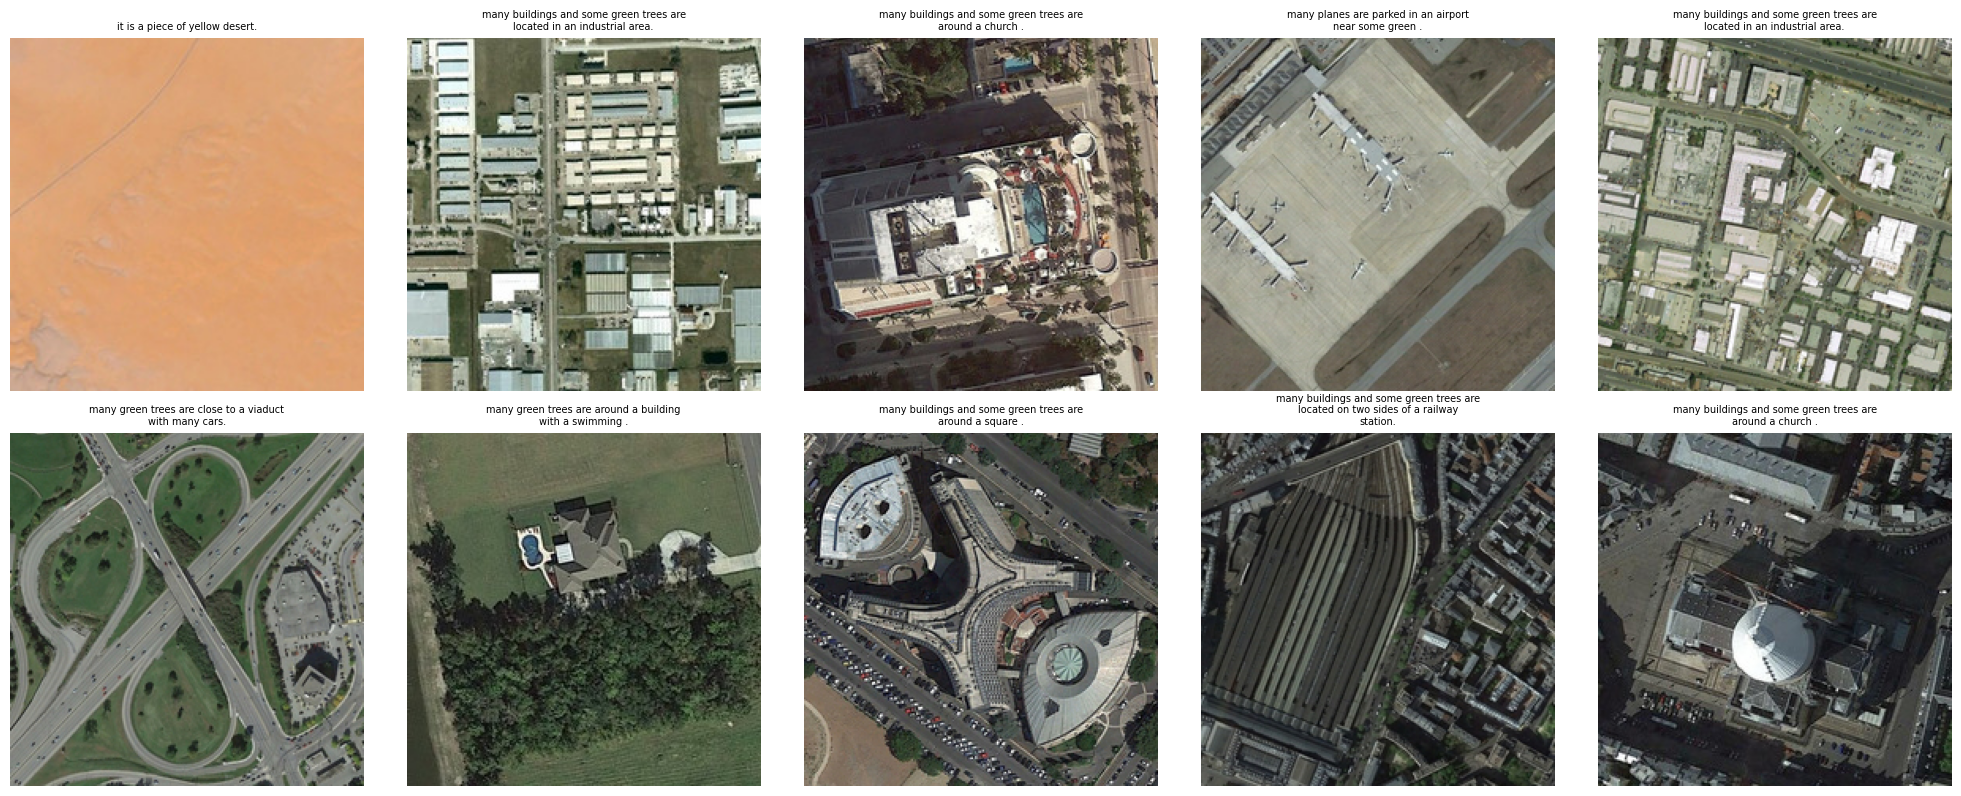

In [15]:
import matplotlib.pyplot as plt
import textwrap
import json

def visualize_predictions(refs, hyps, dataset, num_examples=10):
    indices = random.sample(range(len(refs)), min(num_examples, len(refs)))

    cols = 5
    rows = (num_examples + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = axes.flatten() if num_examples > 1 else [axes]

    for ax_idx, img_idx in enumerate(indices):
        ex = dataset.data[img_idx]
        img_path = ex.get("image_path", ex.get("image"))
        if isinstance(img_path, str):
            image = Image.open(img_path).convert("RGB")
        else:
            image = ex["image"]
            if not isinstance(image, Image.Image):
                image = Image.fromarray(np.array(image))

        axes[ax_idx].imshow(image)
        axes[ax_idx].axis('off')

        pred = hyps[img_idx][0]
        wrapped_pred = textwrap.fill(pred, width=40)
        axes[ax_idx].set_title(wrapped_pred, fontsize=7)

    for ax_idx in range(num_examples, len(axes)):
        axes[ax_idx].axis('off')

    plt.tight_layout()
    plt.savefig('test_predictions.png', dpi=150, bbox_inches='tight')
    print("\nSaved visualization to 'test_predictions.png'")
    plt.show()

print("\nVisualizing random examples...")
visualize_predictions(test_refs, test_hyps, test_data, num_examples=10)


In [16]:
output_file = 'test_predictions.json'
predictions = []
for idx in range(len(test_refs)):
    predictions.append({
        'image_id': idx,
        'ground_truth': test_refs[idx],
        'prediction': test_hyps[idx][0]
    })

with open(output_file, 'w', encoding='utf-8') as f:
    json.dump({
        'metrics': {k: float(v) if v is not None else None for k, v in test_results.items()},
        'predictions': predictions[:100]
    }, f, indent=2, ensure_ascii=False)

print(f"\nSaved predictions to '{output_file}'")


Saved predictions to 'test_predictions.json'
